# Probabilistic Machine Learning - Project Report

**Course:** Probabilistic Machine Learning (SoSe 2025) <br>
**Lecturer:** Dr Alvaro Diaz-Ruelas <br>
**Student(s) Name(s):** Lukas Becker <br>
**GitHub Username(s):**  lbegit <br>
**Date:**  15052025 <br>
**PROJECT-ID:** 15-2BLXXXX_epa_census <br>

---

## 1 Introduction

In recent years, transportation equity and sustainability have become central concerns in urban planning and policy. Among the key indicators of social and infrastructural access is household vehicle ownership, particularly the percentage of households without access or need to a private vehicle. These zero-vehicle households are often more dependent on public transit and walkable environments, and their distribution is shaped by a complex mix of socio-economic, spatial, and infrastructural variables.

This research aims to predict the percentage of car-free households in new and changed US Census Block Groups (CBGs). It is using the US EPA’s Smart Location Database (SLD), a rich source of standardized spatial and socio-economic indicators. The focus is on identifying how evolving social, economic, or political changes, such as new transit infrastructure, economic shifts, or population dynamics, can influence car ownership trends.

To model these dynamics, I will explore a range of machine learning techniques, from linear models like OLS, Lasso, Ridge, Elastic Net, and Bayesian Ridge regression to more sophisticated approaches such as k-Nearest Neighbors and Random Forest. The goal is to determine which models best capture the nuanced, multidimensional patterns influencing car ownership at the CBG level.


The analysis will be conducted using a carefully selected subset of variables from the SLD dataset, chosen for their theoretical relevance and practical predictive potential. These features span demographic composition, employment density, urban design, and transit access. All of which are thought to influence household decisions regarding car ownership.

## 2 Data Loading and Exploration

### 2.1 Prerequisites

#### (i) Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression , Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import statsmodels.api as sm

from sklearn.utils import resample
from tqdm import tqdm  # for progress bar

#### (ii) Functions

In [2]:
def compare_l1_l2_elastic(X_train, X_test, y_train, y_test, dataset_name):
    alphas = np.logspace(-3, 3, 50)
    lasso_mse = []
    ridge_mse = []
    elastic_mse = []

    for alpha in alphas:
        lasso = Lasso(alpha=alpha, max_iter=10000)
        ridge = Ridge(alpha=alpha)
        elastic = ElasticNet(alpha=alpha, l1_ratio=0.5, max_iter=10000)

        lasso.fit(X_train, y_train)
        ridge.fit(X_train, y_train)
        elastic.fit(X_train, y_train)

        y_pred_lasso = lasso.predict(X_test)
        y_pred_ridge = ridge.predict(X_test)
        y_pred_elastic = elastic.predict(X_test)

        lasso_mse.append(mean_squared_error(y_test, y_pred_lasso))
        ridge_mse.append(mean_squared_error(y_test, y_pred_ridge))
        elastic_mse.append(mean_squared_error(y_test, y_pred_elastic))

    plt.figure(figsize=(8,6))
    plt.plot(alphas, lasso_mse, label='Lasso (L1)', marker='o')
    plt.plot(alphas, ridge_mse, label='Ridge (L2)', marker='x')
    plt.plot(alphas, elastic_mse, label='Elastic Net', marker='s')
    plt.xscale('log')
    plt.xlabel('Regularization strength (alpha)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title(f'Comparison of L1, L2 and Elastic Net Regularization on {dataset_name} Dataset')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nBest Lasso (L1) MSE for {dataset_name}: {np.min(lasso_mse):.3f} at alpha={alphas[np.argmin(lasso_mse)]:.3f}")
    print(f"Best Ridge (L2) MSE for {dataset_name}: {np.min(ridge_mse):.3f} at alpha={alphas[np.argmin(ridge_mse)]:.3f}")
    print(f"Best Elastic Net MSE for {dataset_name}: {np.min(elastic_mse):.3f} at alpha={alphas[np.argmin(elastic_mse)]:.3f}")



In [3]:
def metrics(y_test, y_pred):
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print results
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"R² (Coefficient of Determination): {r2:.4f}")

In [4]:
# Bootstrap parameters optimized for large dataset
N_BOOTSTRAP_SAMPLES = 1000  # Fewer samples needed with large N
BOOTSTRAP_SAMPLE_SIZE = 210000  
RANDOM_STATE = 43

def bootstrap_ols_coefficients(X, y, n_bootstrap=N_BOOTSTRAP_SAMPLES, 
                              sample_size=BOOTSTRAP_SAMPLE_SIZE, random_state=RANDOM_STATE):
    """
    Bootstrap OLS coefficients for large datasets
    Handles both numpy arrays and pandas DataFrames/Series correctly
    """
    np.random.seed(random_state)
    n_features = X.shape[1]
    bootstrap_coefs = np.zeros((n_bootstrap, n_features))
    
    #print(f"Running {n_bootstrap} bootstrap samples with {sample_size:,} records each...")
    #print(f"Data types: X={type(X)}, y={type(y)}")
    
    for i in tqdm(range(n_bootstrap)):
        # Resample with replacement
        boot_indices = np.random.choice(len(X), size=sample_size, replace=True)
        
        # Handle X indexing
        if hasattr(X, 'iloc'):  # pandas DataFrame
            X_boot = X.iloc[boot_indices]
        else:  # numpy array
            X_boot = X[boot_indices]
        
        # Handle y indexing
        if hasattr(y, 'iloc'):  
            y_boot = y.iloc[boot_indices]
        else:  # numpy array
            y_boot = y[boot_indices]
        
        # Convert to numpy if needed for sklearn
        if hasattr(X_boot, 'values'):
            X_boot = X_boot.values
        if hasattr(y_boot, 'values'):
            y_boot = y_boot.values
        
        # Fit OLS (using sklearn for speed)
        lr = LinearRegression(fit_intercept=True)
        lr.fit(X_boot, y_boot)
        bootstrap_coefs[i] = lr.coef_
    
    # Calculate mean and standard error
    mean_coefs = np.mean(bootstrap_coefs, axis=0)
    std_errors = np.std(bootstrap_coefs, axis=0, ddof=1)  # ddof=1 for sample std
    
    return mean_coefs, std_errors, bootstrap_coefs

#### (iii) Settings

In [5]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 1000) # Show all columns

### 2.2 Data

#### (i) Preselection of Features

In [6]:
#df = pd.read_csv('/Users/z3/Documents/Studium/1. Semester/ProbML/SmartLocation/EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv')

In [7]:
#selected_df = df[['STATEFP','COUNTYFP','TRACTCE','BLKGRPCE','CSA','CSA_Name','CBSA','CBSA_Name','CBSA_POP','CBSA_EMP','CBSA_WRK','TotPop','HH','P_WrkAge','Pct_AO0','Workers','R_PCTLOWWAGE','TotEmp','E_PctLowWage','D1A','D1B','D1C','D2A_JPHH','D3A','D4A','D4C']].rename(columns={
#'STATEFP': 'STATE_ID','COUNTYFP': 'COUNTY_ID','TRACTCE':'Tract_ID','BLKGRPCE':'Block_Group','CSA': 'CSA','CSA_Name': 'CSA_NAME','CBSA': 'CBSA','CBSA_Name': 'CBSA_NAME','CBSA_POP': 'CBSA_POP','CBSA_EMP': 'CBSA_EMP','CBSA_WRK': 'CBSA_WRK','TotPop': 'TOTAL_POPULATION','HH': 'HOUSEHOLDS','P_WrkAge': 'P_WORKING_AGE','Pct_AO0': 'P_ZERO_CARS_HOUSEHOLDS','Workers': 'WORKERS','R_PCTLOWWAGE': 'P_LOW_WAGE_WORKERS','TotEmp': 'TOTAL_EMPLOYMENT','E_PctLowWage': 'P_LOW_WAGE_EMPLOYMENT','D1A': 'HOUSEHOLD_P_ACRE','D1B': 'POPULATION_P_ACRE','D1C': 'JOBS_P_ACRE', 'D2A_JPHH' : 'JOBS_P_HOUSEHOLD','D3A': 'ROAD_NETWORK_MILES','D4A': 'METERS_NEXT_TRANSIT_STOP','D4C': 'TIMES_P_HOUR_TRANSIT_SERVICE'})


In [8]:
#selected_df.tob_csv('census_data', index=False) 

#### (ii) Feature Description 

| **Column Name**                | **Original Name** | **Description**                                         | **Important for Prediction?** | **Relevance to Car Ownership**                                                              |
| ------------------------------ | ----------------- | ------------------------------------------------------- | ----------------------------- | ------------------------------------------------------------------------------------------- |
| `STATE_ID`                     | `STATEFP`         | State FIPS                                              | No                            | Record identifier |
| `COUNTY_ID`                    | `COUNTYFP`        | County FIPS                                             | No                            | Record identifier |
| `Tract_ID`                     | `TRACTCE`         | Census Tract identifier                                | No                            | Record identifier |
| `Block_Group`                  | `BLKGRPCE`        | Census Block Group code                                | No                            | Record identifier |
| `CSA`                          | `CSA`             | Combined Statistical Area code                         | No                            | Record identifier |
| `CSA_NAME`                     | `CSA_Name`        | Name of the CSA                                        | No                            | Record identifier |
| `CBSA`                         | `CBSA`            | Core-Based Statistical Area code                       | No                            | Record identifier |
| `CBSA_NAME`                    | `CBSA_Name`       | Name of the CBSA                                       | No                            | Record identifier |
| `CBSA_POP`                     | `CBSA_POP`        | Total population in the CBSA                           | Yes                           | Indicates scale of urbanization, which affects transit and car dependency                  |
| `CBSA_EMP`                     | `CBSA_EMP`        | Total employment in CBSA                               | Yes                           | Economic size often correlates with public transportation investment and job accessibility |
| `CBSA_WRK`                     | `CBSA_WRK`        | Workers living in the CBSA                             | Yes                           | Reflects commuting patterns and urban form                                                 |
| `TOTAL_POPULATION`             | `TotPop`          | Total population of the CBG                            | Yes                           | More people can imply denser neighborhoods with better transit                             |
| `HOUSEHOLDS`                   | `HH`              | Number of occupied households                          | Yes                           | Base unit for computing car ownership and household ratios                                 |
| `P_WORKING_AGE`                | `P_WrkAge`        | Percent of population aged 18–64                       | Yes                           | Working-age population drives demand for work-related travel                               |
| `P_ZERO_CARS_HOUSEHOLDS`       | `Pct_AO0`         | Percent of households with zero cars                   | **Target**                    | **This is the variable being predicted**                                                   |
| `WORKERS`                      | `Workers`         | Count of workers living in CBG                         | Yes                           | High numbers of workers may increase car ownership unless transit is strong                |
| `P_LOW_WAGE_WORKERS`           | `R_PCTLOWWAGE`    | Share of workers earning ≤\$1,250/month                | Yes                           | Low-income households are more likely to be car-free                                       |
| `TOTAL_EMPLOYMENT`             | `TotEmp`          | Number of jobs located in the CBG                      | Yes                           | More nearby jobs may reduce need for car commuting                                         |
| `P_LOW_WAGE_EMPLOYMENT`        | `E_PctLowWage`    | Share of local jobs that are low wage                  | Yes                           | Indicates local affordability and types of employment accessible without a car             |
| `HOUSEHOLD_P_ACRE`             | `D1A`             | Residential density (HHs per acre of unprotected land) | Yes                           | Denser housing often supports transit and walking                                          |
| `POPULATION_P_ACRE`            | `D1B`             | Population density per acre                            | Yes                           | Key factor in predicting transit viability and car ownership                               |
| `JOBS_P_ACRE`                  | `D1C`             | Job density per acre                                   | Yes                           | Dense employment centers reduce reliance on personal vehicles                              |
| `JOBS_P_HOUSEHOLD`             | `D2A_JPHH`        | Ratio of jobs to households                            | Yes                           | Indicates job-housing balance, affecting travel needs                                      |
| `ROAD_NETWORK_MILES`      | `D3A`           | Miles roads per square mile           | Yes                           | Roads are mostly car-oriented infrastructure and often correlate with higher car ownership                |
| `METERS_NEXT_TRANSIT_STOP`     | `D4A`             | Distance to nearest transit stop (meters)              | Yes                           | Key factor—longer distances reduce the viability of car-free living                        |
| `TIMES_P_HOUR_TRANSIT_SERVICE` | `D4C`             | Frequency of transit service near CBG during peak hour | Yes                           | More frequent service supports households not owning cars                                  |


#### (iii) Load

In [9]:
# Load csv 
df_org = pd.read_csv('/Users/z3/Documents/Studium/1. Semester/ProbML/Probabilistic-Machine-Learning_lecture-PROJECTS/projects/15-2BLXXXX_epa_census/data/census_data')

In [10]:
df = df_org.copy()

### 2.3 Preparation

#### (i) Null-Values

In [11]:
df.isnull().sum()

STATE_ID                            0
COUNTY_ID                           0
Tract_ID                            0
Block_Group                         0
CSA                             53031
CSA_NAME                        53031
CBSA                            17095
CBSA_NAME                       17095
CBSA_POP                            0
CBSA_EMP                            0
CBSA_WRK                            0
TOTAL_POPULATION                    0
HOUSEHOLDS                        275
P_WORKING_AGE                       0
P_ZERO_CARS_HOUSEHOLDS              0
WORKERS                             0
P_LOW_WAGE_WORKERS                  0
TOTAL_EMPLOYMENT                    0
P_LOW_WAGE_EMPLOYMENT               0
HOUSEHOLD_P_ACRE                  271
POPULATION_P_ACRE                   0
JOBS_P_ACRE                         0
JOBS_P_HOUSEHOLD                    0
ROAD_NETWORK_MILES                  0
METERS_NEXT_TRANSIT_STOP            0
TIMES_P_HOUR_TRANSIT_SERVICE        0
dtype: int64

##### Missing CSA and CBSA Values
I have a lot of Null-Values in CSA and CBSA Columns. These are just additional location information and no features. I will not use them in the model. They are only useful to get information about individual elements. But they are correlated with zero values in CBSA_POP, CBSA_EMP, CBSA_WRK. These Features should and will not be used in the model. 

In [12]:
df[(df['CBSA_POP']==0) | (df['CBSA_EMP']==0) | (df['CBSA_WRK']==0)]

,STATE_ID,COUNTY_ID,Tract_ID,Block_Group,CSA,CSA_NAME,CBSA,CBSA_NAME,CBSA_POP,CBSA_EMP,CBSA_WRK,TOTAL_POPULATION,HOUSEHOLDS,P_WORKING_AGE,P_ZERO_CARS_HOUSEHOLDS,WORKERS,P_LOW_WAGE_WORKERS,TOTAL_EMPLOYMENT,P_LOW_WAGE_EMPLOYMENT,HOUSEHOLD_P_ACRE,POPULATION_P_ACRE,JOBS_P_ACRE,JOBS_P_HOUSEHOLD,ROAD_NETWORK_MILES,METERS_NEXT_TRANSIT_STOP,TIMES_P_HOUR_TRANSIT_SERVICE
78,48,421,950200,2,NaN,NaN,NaN,NaN,0,0,0,1718,585.0,0.590,0.034188,454,0.196035,611,0.170213,1.038652,2.541886,0.904012,1.044444,21.685255,-99999.0,-99999.0
301,48,331,950700,3,NaN,NaN,NaN,NaN,0,0,0,541,220.0,0.416,0.068182,402,0.233831,245,0.200000,0.250029,0.491875,0.222753,1.113636,7.396807,-99999.0,-99999.0
302,48,331,950700,4,NaN,NaN,NaN,NaN,0,0,0,861,431.0,0.696,0.081206,419,0.264916,300,0.186667,0.817271,1.453864,0.506573,0.696056,13.665453,-99999.0,-99999.0
303,48,331,950700,5,NaN,NaN,NaN,NaN,0,0,0,2513,908.0,0.526,0.000000,769,0.221066,131,0.282443,0.882287,2.441836,0.127290,0.144273,9.107649,-99999.0,-99999.0
307,48,207,950300,3,NaN,NaN,NaN,NaN,0,0,0,824,336.0,0.525,0.065476,371,0.304582,83,0.277108,0.559090,1.104773,0.111282,0.247024,11.356720,-99999.0,-99999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220735,78,30,961000,2,NaN,NaN,NaN,NaN,0,0,0,1471,573.0,0.000,0.000000,0,0.000000,0,0.000000,8.761019,18.813808,0.000000,0.000000,33.948142,-99999.0,-99999.0
220736,78,30,961000,3,NaN,NaN,NaN,NaN,0,0,0,940,418.0,0.000,0.000000,0,0.000000,0,0.000000,8.040306,13.008412,0.000000,0.000000,39.675163,-99999.0,-99999.0
220737,78,30,961000,5,NaN,NaN,NaN,NaN,0,0,0,878,403.0,0.000,0.000000,0,0.000000,0,0.000000,12.545333,21.941838,0.000000,0.000000,32.111446,-99999.0,-99999.0
220738,78,30,960700,3,NaN,NaN,NaN,NaN,0,0,0,1278,613.0,0.000,0.000000,0,0.000000,0,0.000000,1.404107,1.485471,0.000000,0.000000,14.657562,-99999.0,-99999.0


##### Missing Households Values

In [13]:
# Comparing households_null_values with special_territories with state identity 66 and 69

households_null_df = df[df['HOUSEHOLDS'].isnull() | df['HOUSEHOLD_P_ACRE'].isnull()]
special_territories_df = df[df['STATE_ID'].isin([66, 69])] 

same_indices = households_null_df.index.equals(special_territories_df.index)
print(same_indices)  # True if exactly same rows selected

True


The values match the total number of elements from "Northern Mariana Islands" and "Guam". Because they are missing in total and this are special territories, I will drop them. I also will drop other special territories which are not American states:

In [14]:
# Drop all special territories
df = df[df['STATE_ID']<=56] 

#### (ii) Values

In [15]:
df.describe()

,STATE_ID,COUNTY_ID,Tract_ID,Block_Group,CSA,CBSA,CBSA_POP,CBSA_EMP,CBSA_WRK,TOTAL_POPULATION,HOUSEHOLDS,P_WORKING_AGE,P_ZERO_CARS_HOUSEHOLDS,WORKERS,P_LOW_WAGE_WORKERS,TOTAL_EMPLOYMENT,P_LOW_WAGE_EMPLOYMENT,HOUSEHOLD_P_ACRE,POPULATION_P_ACRE,JOBS_P_ACRE,JOBS_P_HOUSEHOLD,ROAD_NETWORK_MILES,METERS_NEXT_TRANSIT_STOP,TIMES_P_HOUR_TRANSIT_SERVICE
count,217739.000000,217739.000000,217739.000000,217739.000000,165358.000000,201066.000000,2.177390e+05,2.177390e+05,2.177390e+05,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000,217739.000000
mean,28.032071,85.893896,260341.890681,2.222836,339.877611,30438.240379,3.640101e+06,1.706534e+06,1.657484e+06,1482.982056,549.879112,0.596186,0.092067,646.607498,0.237747,647.915008,0.295959,4.525163,10.445416,3.825622,1.793225,15.762961,-56542.004006,-53413.498352
std,15.697888,99.319321,350582.092807,1.195316,125.530744,10955.270410,5.246923e+06,2.487643e+06,2.409038e+06,990.394957,339.914770,0.102778,0.135699,416.995859,0.056450,2033.839914,0.151614,13.938563,29.280778,46.708921,38.854630,10.709707,49768.726104,49889.750594
min,1.000000,1.000000,100.000000,0.000000,104.000000,10100.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-99999.000000,-99999.000000
25%,13.000000,29.000000,10300.000000,1.000000,216.000000,19740.000000,2.058140e+05,8.365800e+04,8.366200e+04,891.000000,342.000000,0.544000,0.010289,391.000000,0.203509,73.000000,0.191916,0.295216,0.701898,0.085160,0.151659,5.605491,-99999.000000,-99999.000000
50%,28.000000,61.000000,43900.000000,2.000000,356.000000,32580.000000,1.252890e+06,5.950500e+05,5.656950e+05,1267.000000,477.000000,0.595000,0.043400,555.000000,0.232787,205.000000,0.281481,1.841697,4.318367,0.555907,0.406849,15.643013,-99999.000000,-99999.000000
75%,41.000000,109.000000,480400.000000,3.000000,428.000000,39150.000000,4.673634e+06,2.400290e+06,2.241034e+06,1818.000000,674.000000,0.649000,0.113757,797.000000,0.267123,557.000000,0.381818,4.140478,10.095174,2.200705,1.070707,23.363958,346.010000,4.670000
max,56.000000,840.000000,992201.000000,9.000000,566.000000,49820.000000,1.931847e+07,9.159786e+06,8.946175e+06,55407.000000,21337.000000,1.000000,1.000000,19255.000000,1.000000,266101.000000,1.000000,1481.257220,3133.578265,14032.760640,12325.666670,166.894521,1207.000000,973.670000


##### High values of population

In [16]:
df[df['TOTAL_POPULATION']>30000]

,STATE_ID,COUNTY_ID,Tract_ID,Block_Group,CSA,CSA_NAME,CBSA,CBSA_NAME,CBSA_POP,CBSA_EMP,CBSA_WRK,TOTAL_POPULATION,HOUSEHOLDS,P_WORKING_AGE,P_ZERO_CARS_HOUSEHOLDS,WORKERS,P_LOW_WAGE_WORKERS,TOTAL_EMPLOYMENT,P_LOW_WAGE_EMPLOYMENT,HOUSEHOLD_P_ACRE,POPULATION_P_ACRE,JOBS_P_ACRE,JOBS_P_HOUSEHOLD,ROAD_NETWORK_MILES,METERS_NEXT_TRANSIT_STOP,TIMES_P_HOUR_TRANSIT_SERVICE
1232,48,157,672900,1,288.0,"Houston-The Woodlands, TX",26420.0,"Houston-The Woodlands-Sugar Land, TX",6779104,2975382,2886903,51536,15407.0,0.627,0.002402,18918,0.186330,3017,0.421279,1.374236,4.410976,0.258226,0.195820,14.486178,-99999.00,-99999.00
14654,48,157,673101,1,288.0,"Houston-The Woodlands, TX",26420.0,"Houston-The Woodlands-Sugar Land, TX",6779104,2975382,2886903,55407,15298.0,0.561,0.010132,14430,0.152460,17541,0.202839,1.742049,6.051140,1.915697,1.146620,18.092143,-99999.00,-99999.00
41412,6,73,18700,1,NaN,NaN,41740.0,"San Diego-Chula Vista-Carlsbad, CA",3302833,1403191,1419381,38932,6877.0,0.748,0.000000,6608,0.236229,1848,0.174242,0.057605,0.293930,0.013952,0.268722,2.366354,-99999.00,12.00
63625,12,119,911200,1,422.0,"Orlando-Lakeland-Deltona, FL",45540.0,"The Villages, FL",120999,25547,23986,39919,21337.0,0.198,0.015091,5856,0.400615,5409,0.317989,2.401617,3.626500,0.491389,0.253503,16.229679,-99999.00,-99999.00
69848,12,95,16730,1,422.0,"Orlando-Lakeland-Deltona, FL",36740.0,"Orlando-Kissimmee-Sanford, FL",2450261,1262313,1135710,31938,10189.0,0.603,0.024438,14402,0.205458,2278,0.366550,1.970425,5.639018,0.402207,0.223574,11.420017,-99999.00,0.33
170662,38,17,40500,2,244.0,"Fargo-Wahpeton, ND-MN",22020.0,"Fargo, ND-MN",237003,137770,122263,39283,15893.0,0.665,0.032908,19255,0.188990,11131,0.250292,0.565242,1.300023,0.368367,0.700371,7.012611,380.88,3.00


Unusually high values of population checked; Example Element 14654 validated by https://datacommons.org/browser/geoId/481576731011

Theory: I think this high values exist because of rapid population growth.

#### (iv) Final data selection

In [17]:
feature_df = df.iloc[:, 11:].copy()
#feature_df = feature_df.drop('POPULATION_P_ACRE', axis=1)

## 3 Data Preprocessing

### 3.1 Feature Engineering

#### Threshold Values for Transit Features:

METERS_NEXT_TRANSIT_ STOP: 'All CBGs with population-weighted centroids that were further than three-quarter miles (12 km) from a transit stop were assigned a value of “-99999”'

This are bad placeholders because it should be a high positive value to show that a transit stop is far away

In [19]:
#feature_df[feature_df['METERS_NEXT_TRANSIT_STOP']==-99999]

TIMES_P_HOUR_TRANSIT_SERVICE: 'CBGs in areas that do not have transit service were assigned the value “-99999”'

This are bad placeholders because it should be a zero to show that there is 0 times per hour

In [20]:
#feature_df[feature_df['TIMES_P_HOUR_TRANSIT_SERVICE']==-99999]

In [21]:
# Replacing placeholder values with null
feature_df['METERS_NEXT_TRANSIT_STOP'] = feature_df['METERS_NEXT_TRANSIT_STOP'].replace(-99999, np.nan)
feature_df['TIMES_P_HOUR_TRANSIT_SERVICE'] = feature_df['TIMES_P_HOUR_TRANSIT_SERVICE'].replace(-99999, np.nan)

# Create new binary feature no_transit
feature_df.loc[:, 'no_transit'] = feature_df['METERS_NEXT_TRANSIT_STOP'].isna().astype(int)

# Fill Features with suiting values
feature_df.loc[:, 'METERS_NEXT_TRANSIT_STOP'] = feature_df['METERS_NEXT_TRANSIT_STOP'].fillna(2000) # max of other data is 1200
feature_df.loc[:, 'TIMES_P_HOUR_TRANSIT_SERVICE'] = feature_df['TIMES_P_HOUR_TRANSIT_SERVICE'].fillna(0) # minimum value of zero

<span style="color:red">Question: </span> Is changing values like this legitimate?

In [22]:
feature_df['P_ZERO_CARS_HOUSEHOLDS'].describe()

count    217739.000000
mean          0.092067
std           0.135699
min           0.000000
25%           0.010289
50%           0.043400
75%           0.113757
max           1.000000
Name: P_ZERO_CARS_HOUSEHOLDS, dtype: float64

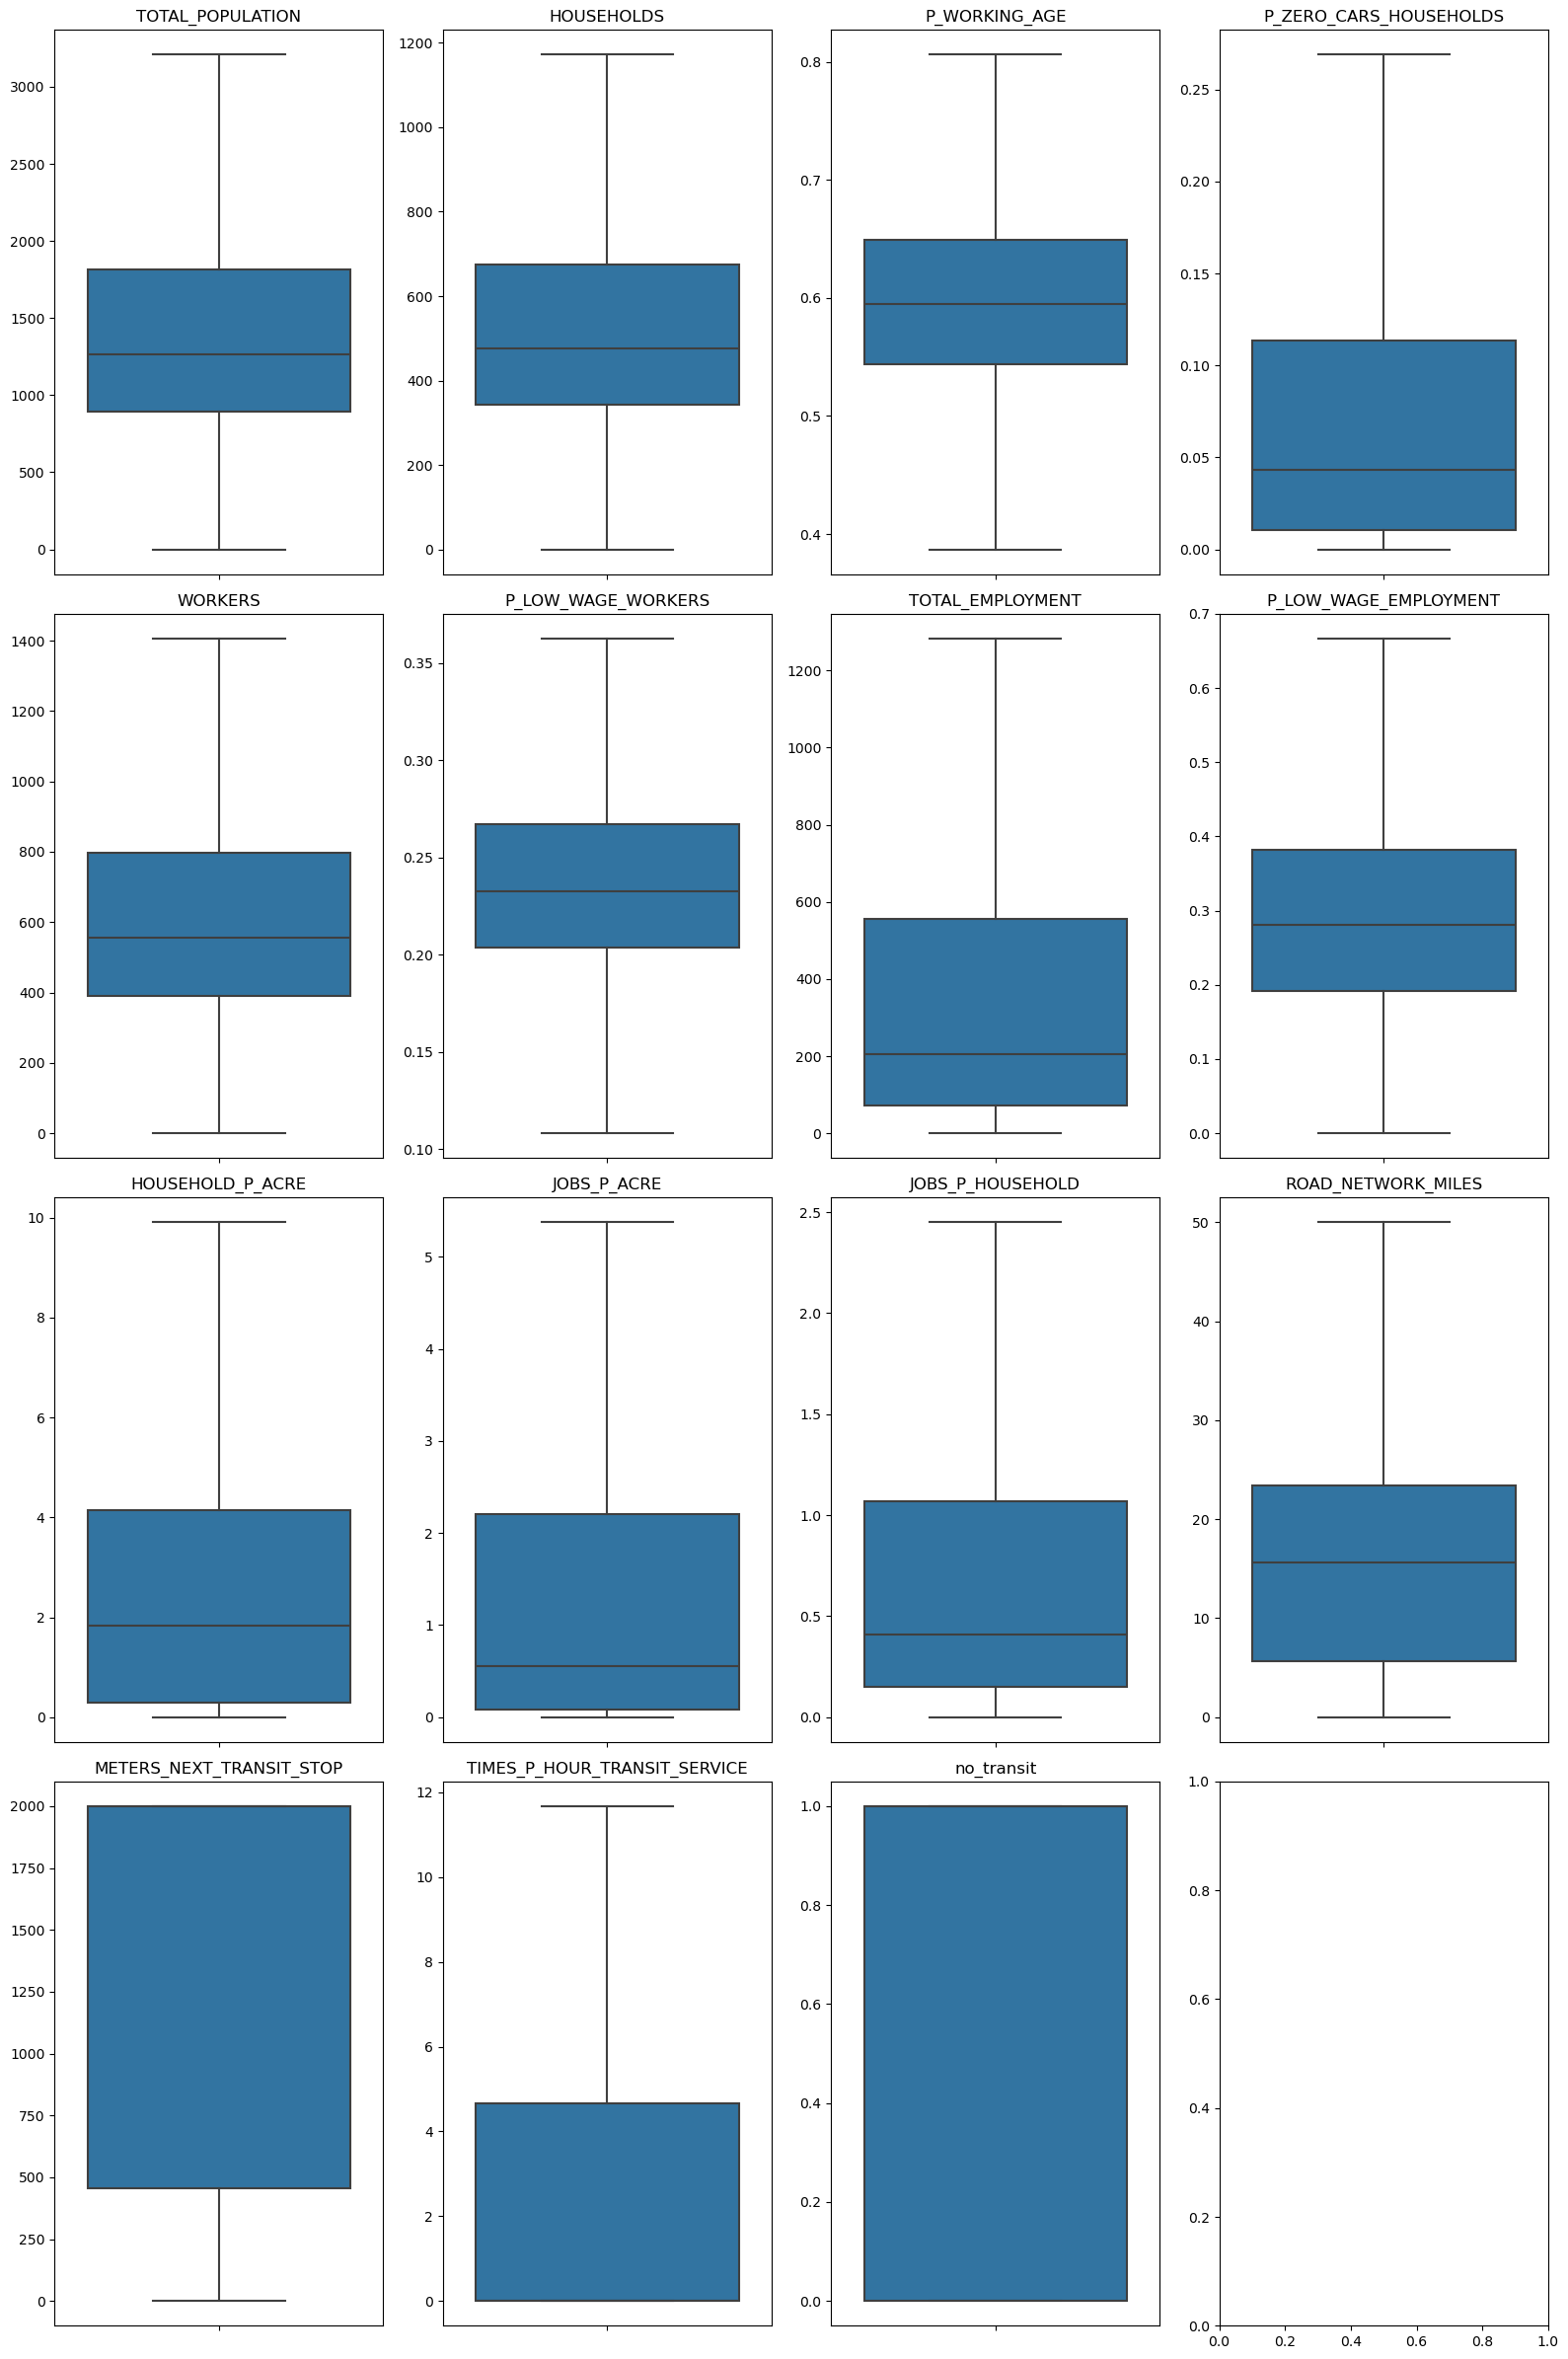

In [23]:
feature_df_numeric = feature_df.iloc[:, :]
num_cols = feature_df_numeric.shape[1]

# Create subplots: 4 rows and 4 columns
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(4 * 4, 6 * 4), sharey=False)

# Flatten the 2D axes array for easier iteration
axes = axes.flatten()

# Plot each column in its own subplot
for i, col in enumerate(feature_df_numeric.columns):
    sns.boxplot(y=feature_df_numeric[col], ax=axes[i], showfliers=False)
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')


plt.tight_layout()
plt.show()

In [24]:
print((feature_df == 0).sum())

TOTAL_POPULATION                  1057
HOUSEHOLDS                        1507
P_WORKING_AGE                     1081
P_ZERO_CARS_HOUSEHOLDS           49123
WORKERS                            705
P_LOW_WAGE_WORKERS                 871
TOTAL_EMPLOYMENT                  2162
P_LOW_WAGE_EMPLOYMENT             4426
HOUSEHOLD_P_ACRE                  1455
JOBS_P_ACRE                       2166
JOBS_P_HOUSEHOLD                  2924
ROAD_NETWORK_MILES                 586
METERS_NEXT_TRANSIT_STOP          3106
TIMES_P_HOUR_TRANSIT_SERVICE    116318
no_transit                       94196
dtype: int64


The distributions look plausible.

<span style="color:red">Question: </span> 

I have a lot of elements which have no_transit: 56%. Does this effect my regression in any way?

Do I have to handle strong outliers like POPULATION_P_ACRE with max: 3133 and mean: 10?

### 3.2 Correlation

In [25]:
#feature_df

In [26]:
correlation_matrix = feature_df.corr(numeric_only=True)

In [27]:
#correlation_matrix.round(2)

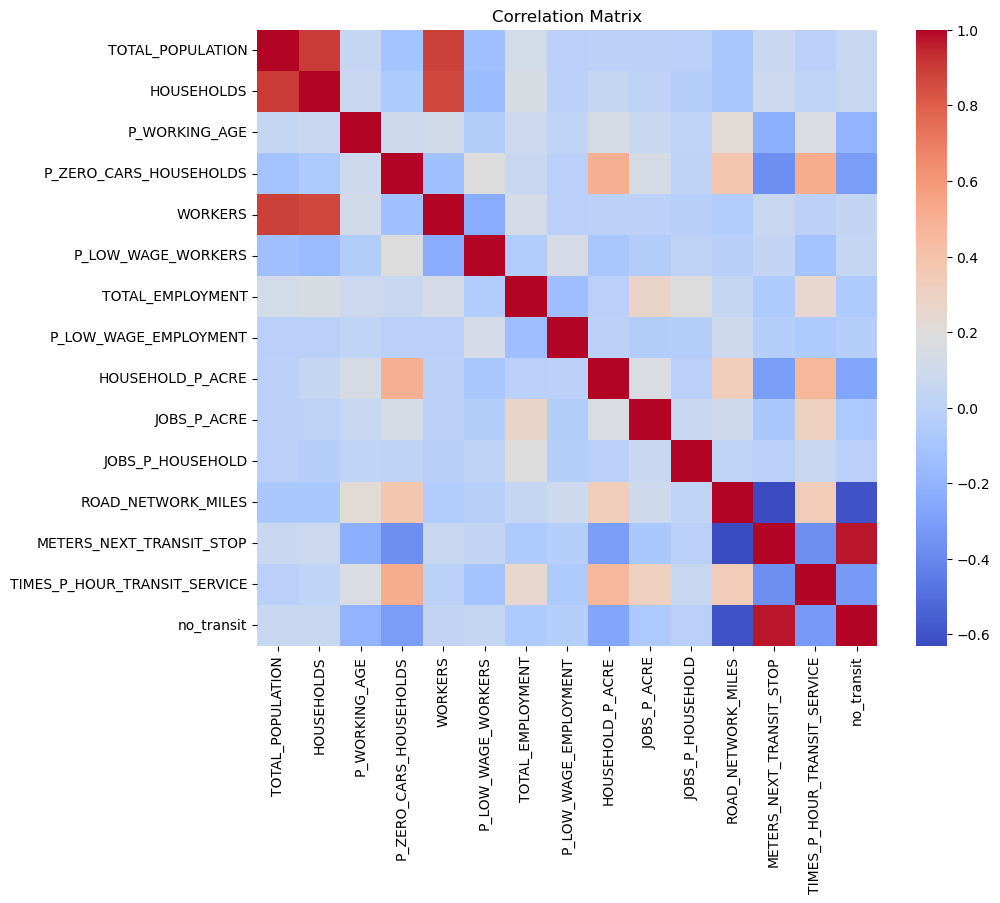

In [28]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.round(2), annot=False, cmap='coolwarm', fmt="2f")
plt.title("Correlation Matrix")
plt.show()

There are some pairs of variables displaying significant correlation.

## 4 Probabilistic Modeling Approach

### 4.1 Linear Models

#### (i) **Ordinary Least Squares (OLS)**

OLS minimizes the residual sum of squares:

$$
\hat{\beta} = \arg\min_{\beta} \| y - X\beta \|^2
$$

**Suitability**: OLS serves as a baseline due to its interpretability and closed-form solution. However, it may overfit in the presence of multicollinearity or noisy features.

---

#### (ii) **Ridge Regression (L2 Regularization)**

Ridge regression introduces an L2 penalty on the coefficients:

$$
\hat{\beta}_{\text{ridge}} = \arg\min_{\beta} \| y - X\beta \|^2 + \lambda \| \beta \|_2^2
$$

**Suitability**: Helps control overfitting by shrinking coefficients. Useful when predictors are correlated.

---

#### (iii) **Lasso Regression (L1 Regularization)**

Lasso regression introduces an L1 penalty:

$$
\hat{\beta}_{\text{lasso}} = \arg\min_{\beta} \| y - X\beta \|^2 + \lambda \| \beta \|_1
$$

**Suitability**: Encourages sparsity in coefficients and performs automatic feature selection.

---

#### (iv) **Elastic Net**

Elastic Net combines L1 and L2 regularization:

$$
\hat{\beta}_{\text{EN}} = \arg\min_{\beta} \| y - X\beta \|^2 + \lambda_1 \| \beta \|_1 + \lambda_2 \| \beta \|_2^2
$$

**Suitability**: Useful when there are many correlated features. Balances sparsity and regularization.

---

#### (v) **Bayesian Ridge Regression**

A probabilistic version of Ridge regression, assuming priors:

$$
p(\beta) = \mathcal{N}(0, \alpha^{-1} I), \quad p(y \mid X, \beta) = \mathcal{N}(X\beta, \eta^{-1} I)
$$

The posterior is:

$$
p(\beta \mid D) = \mathcal{N}(\mathbf{m}_N, \mathbf{S}_N)
$$

$$
\mathbf{S}_N = (\alpha I + \eta X^T X)^{-1}, \quad \mathbf{m}_N = \eta \mathbf{S}_N X^T y
$$

**Suitability**: Captures uncertainty in weights and includes automatic regularization.

---

### 4.2 Nonlinear Models

To address potential nonlinear relationships in the data, I explored the following models.

---

#### (i) **k-Nearest Neighbors (k-NN) Regression**

Predicts by averaging the target values of the k-nearest neighbors:

$$
\hat{y}(x) = \frac{1}{k} \sum_{i \in \mathcal{N}_k(x)} y_i
$$

**Suitability**: Non-parametric, data-driven. Best for low-dimensional, smooth problems.

---

#### (ii) **Random Forest Regressor**

An ensemble of decision trees trained on bootstrapped samples:

$$
\hat{y} = \frac{1}{T} \sum_{t=1}^{T} f_t(x)
$$

**Suitability**: Captures nonlinear interactions and is robust to overfitting. Suitable for bounded outputs and tabular data.

---

### 4.3 Summary of Suitability

| Model                | Strengths                                   | When to Use                                 |
|---------------------|---------------------------------------------|---------------------------------------------|
| OLS                 | Simple, interpretable                       | When relationships are linear               |
| Ridge               | Handles multicollinearity                   | Many correlated predictors                  |
| Lasso               | Feature selection                           | When sparsity is desired                    |
| Elastic Net         | Hybrid regularization                       | Correlated + sparse features                |
| Bayesian Ridge      | Uncertainty-aware, regularized              | Noisy/small data, Bayesian interpretation   |
| k-NN                | Simple, local, non-parametric               | Small, low-dim, smooth data                 |
| Random Forest       | Nonlinear, robust, interpretable            | Tabular data, feature interactions          |

## 5 Model Training and Evaluation

- Training process
- Model evaluation (metrics, plots, performance)
- Cross-validation or uncertainty quantification

### 5.1 Data

#### (i) Overview

In [29]:
feature_df

,TOTAL_POPULATION,HOUSEHOLDS,P_WORKING_AGE,P_ZERO_CARS_HOUSEHOLDS,WORKERS,P_LOW_WAGE_WORKERS,TOTAL_EMPLOYMENT,P_LOW_WAGE_EMPLOYMENT,HOUSEHOLD_P_ACRE,JOBS_P_ACRE,JOBS_P_HOUSEHOLD,ROAD_NETWORK_MILES,METERS_NEXT_TRANSIT_STOP,TIMES_P_HOUR_TRANSIT_SERVICE,no_transit
0,1202,423.0,0.549,0.163121,412,0.240291,66,0.318182,6.250422,0.896800,0.156028,23.534900,362.10,4.33,0
1,710,409.0,0.466,0.000000,395,0.192405,25,0.400000,3.430799,0.209707,0.061125,22.893366,718.84,4.33,0
2,737,329.0,0.811,0.057751,463,0.293737,0,0.000000,13.843035,0.000000,0.000000,14.210509,398.31,3.00,0
3,904,384.0,0.638,0.000000,431,0.139211,253,0.478261,3.225246,2.124967,0.658854,32.178373,386.24,6.67,0
4,948,343.0,0.506,0.014577,579,0.157168,32,0.187500,2.305992,0.215136,0.093294,22.058651,638.37,6.67,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217734,1251,557.0,0.580,0.034111,601,0.221298,49,0.306122,3.166905,0.263909,0.087971,23.012779,2000.00,0.00,1
217735,1292,473.0,0.593,0.000000,513,0.214425,310,0.203226,1.330228,0.823095,0.655391,20.675338,2000.00,0.00,1
217736,1055,456.0,0.596,0.046053,494,0.251012,228,0.478070,3.702966,1.851483,0.500000,28.198149,2000.00,0.00,1
217737,833,425.0,0.586,0.120000,351,0.236467,497,0.271630,0.002295,0.002241,1.169412,0.799596,2000.00,0.00,1


#### (ii) Splitting

In [30]:
y = feature_df["P_ZERO_CARS_HOUSEHOLDS"]
X = feature_df.drop(columns=["P_ZERO_CARS_HOUSEHOLDS","no_transit"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

#### (iii) Standardization

In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 5.2 Linear Models

#### (i) OLS

In [32]:
model = LinearRegression()
OLS_model = model.fit(X_train_scaled, y_train)
y_pred = OLS_model.predict(X_test_scaled)

metrics(y_test, y_pred)

Mean Squared Error (MSE): 0.009818
Root Mean Squared Error (RMSE): 0.099085
Mean Absolute Error (MAE): 0.065286
R² (Coefficient of Determination): 0.4646


#### (ii) L1 & L2

##### Determination of Alpha:


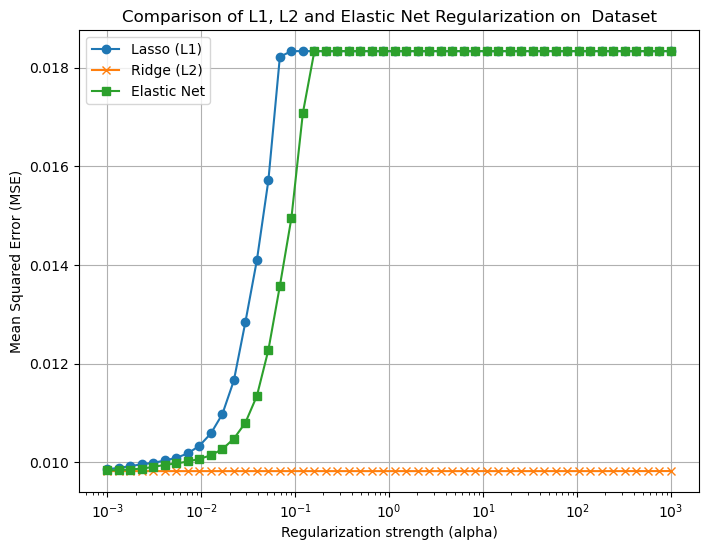


Best Lasso (L1) MSE for : 0.010 at alpha=0.001
Best Ridge (L2) MSE for : 0.010 at alpha=0.001
Best Elastic Net MSE for : 0.010 at alpha=0.001


In [33]:
compare_l1_l2_elastic(X_train_scaled, X_test_scaled, y_train, y_test, "")

##### Ridge

In [34]:
model = Ridge(alpha=0.001)
Ridge_model = model.fit(X_train_scaled, y_train)

y_pred = Ridge_model.predict(X_test_scaled)

metrics(y_test, y_pred)

Mean Squared Error (MSE): 0.009818
Root Mean Squared Error (RMSE): 0.099085
Mean Absolute Error (MAE): 0.065286
R² (Coefficient of Determination): 0.4646


##### Lasso

In [35]:
model = Lasso(alpha=0.001)
Lasso_model = model.fit(X_train_scaled, y_train)

y_pred = Lasso_model.predict(X_test_scaled)

metrics(y_test, y_pred)

Mean Squared Error (MSE): 0.009857
Root Mean Squared Error (RMSE): 0.099285
Mean Absolute Error (MAE): 0.065357
R² (Coefficient of Determination): 0.4624


##### ElasticNet

In [36]:
model = ElasticNet(alpha=0.001, l1_ratio=1)
EN_model = model.fit(X_train_scaled, y_train)

y_pred = EN_model.predict(X_test_scaled)

metrics(y_test, y_pred)

Mean Squared Error (MSE): 0.009857
Root Mean Squared Error (RMSE): 0.099285
Mean Absolute Error (MAE): 0.065357
R² (Coefficient of Determination): 0.4624


#### (iii) Bayesian Regression

In [37]:
model = BayesianRidge()
Bayesian_model = model.fit(X_train_scaled, y_train)

y_pred = Bayesian_model.predict(X_test_scaled)

metrics(y_test, y_pred)

Mean Squared Error (MSE): 0.009818
Root Mean Squared Error (RMSE): 0.099085
Mean Absolute Error (MAE): 0.065286
R² (Coefficient of Determination): 0.4646


#### (iv) Regularization

Regularization has no benefit in this case. 

Reasons:

No overfitting:

In [38]:
# Ridge: Test and Train prediction comparison 
y_pred = Ridge_model.predict(X_test_scaled)
print("Metrics for test data:")
metrics(y_test, y_pred)

print("")

y_pred = Ridge_model.predict(X_train_scaled)
print("Metrics for train data:")
metrics(y_train, y_pred)

Metrics for test data:
Mean Squared Error (MSE): 0.009818
Root Mean Squared Error (RMSE): 0.099085
Mean Absolute Error (MAE): 0.065286
R² (Coefficient of Determination): 0.4646

Metrics for train data:
Mean Squared Error (MSE): 0.010103
Root Mean Squared Error (RMSE): 0.100511
Mean Absolute Error (MAE): 0.065632
R² (Coefficient of Determination): 0.4519


Standardization:

In [39]:
y_pred = Ridge_model.predict(X_test_scaled)

print("R² for scaled data:", r2_score(y_test, y_pred))

print()

model = Ridge(alpha=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("R² for not scaled data:", r2_score(y_test, y_pred))

R² for scaled data: 0.46456263772490547

R² for not scaled data: 0.4645699047093351


Conclusion: L1 & L2 norms are not helping because the model is already well-behaved. there is no overfitting, and the features aren't causing instability in coefficient estimation.

### 5.3 Non Linear Models 

#### (i) k-NN

In [40]:
knn = KNeighborsRegressor(n_neighbors=5)
knn_model = knn.fit(X_train_scaled, y_train)

y_pred = knn_model.predict(X_test_scaled)

metrics(y_test, y_pred)

Mean Squared Error (MSE): 0.008347
Root Mean Squared Error (RMSE): 0.091360
Mean Absolute Error (MAE): 0.059688
R² (Coefficient of Determination): 0.5448


#### (ii) Random Forest Regressor

In [41]:
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split = 10,
    min_samples_leaf = 4,
    random_state=43,
    n_jobs=-1         
)
RF_model = model.fit(X_train_scaled, y_train)

y_pred = RF_model.predict(X_test_scaled)

metrics(y_test, y_pred)

Mean Squared Error (MSE): 0.006929
Root Mean Squared Error (RMSE): 0.083238
Mean Absolute Error (MAE): 0.055291
R² (Coefficient of Determination): 0.6221


### 5.4 Boundaries

#### (i) Linear Models

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


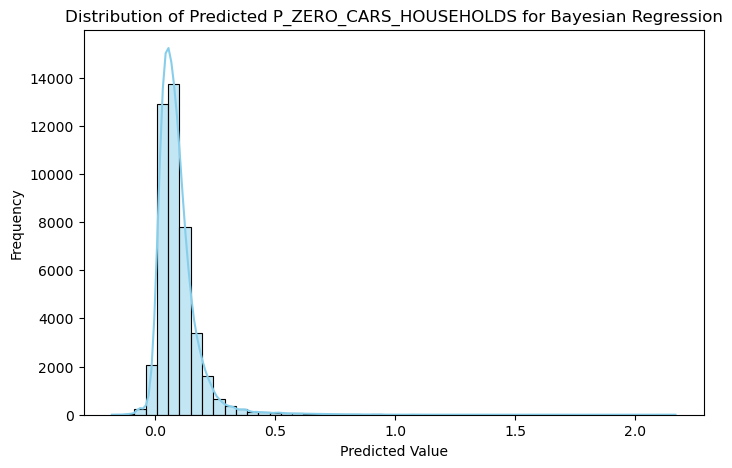

In [42]:
y_pred = Bayesian_model.predict(X_test_scaled)

# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(y_pred, bins=50, kde=True, color='skyblue')
plt.title("Distribution of Predicted P_ZERO_CARS_HOUSEHOLDS for Bayesian Regression")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.show()



There are predictions in Linear Regression which are negative or above 1.0. These are wrong because percentage has a boundary from 0 to 1

#### (ii) Non Linear Models

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


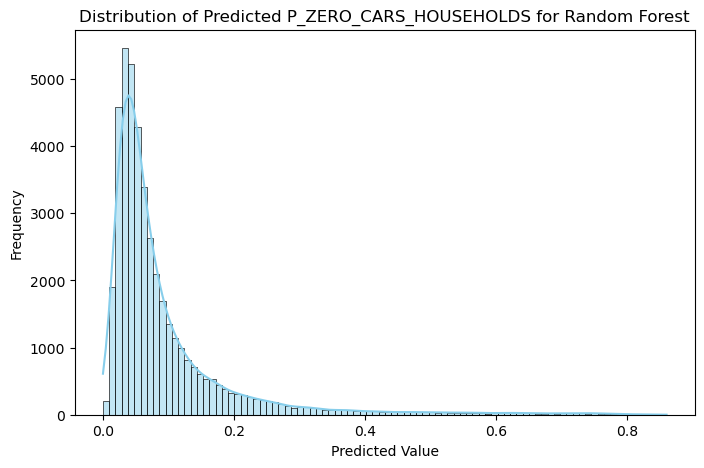

In [43]:
y_pred = RF_model.predict(X_test_scaled)

# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(y_pred, bins=90, kde=True, color='skyblue')
plt.title("Distribution of Predicted P_ZERO_CARS_HOUSEHOLDS for Random Forest")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.show()



The non linear Model finds the right boundaries

### 5.5 Skewed Target 

(P_ZERO_CARS_HOUSEHOLDS) has a very skewed distribution
(Mean ≈ 0.09, Median ≈ 0.04, Max = 1.0)

#### (i) Test data

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


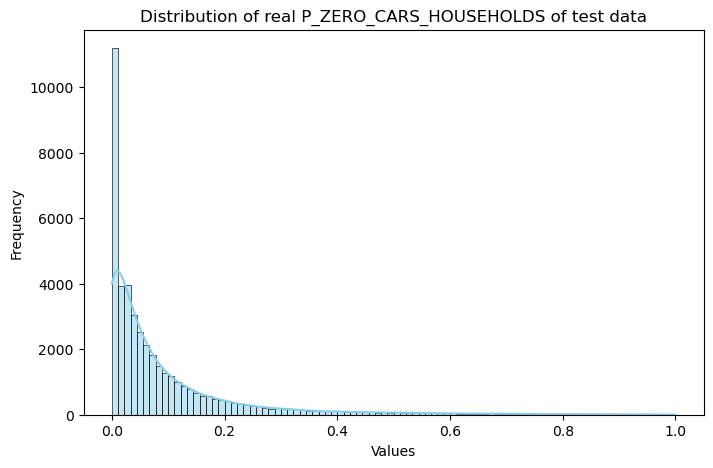

In [44]:
# Plot distribution of P_ZERO_CARS_HOUSEHOLDS Test
plt.figure(figsize=(8, 5))
sns.histplot(y_test, bins=90, kde=True, color='skyblue')
plt.title("Distribution of real P_ZERO_CARS_HOUSEHOLDS of test data")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()

The data is skewed with a high number of records with 0 values. These are rural areas with no transit. 

#### (ii) Random Forest

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


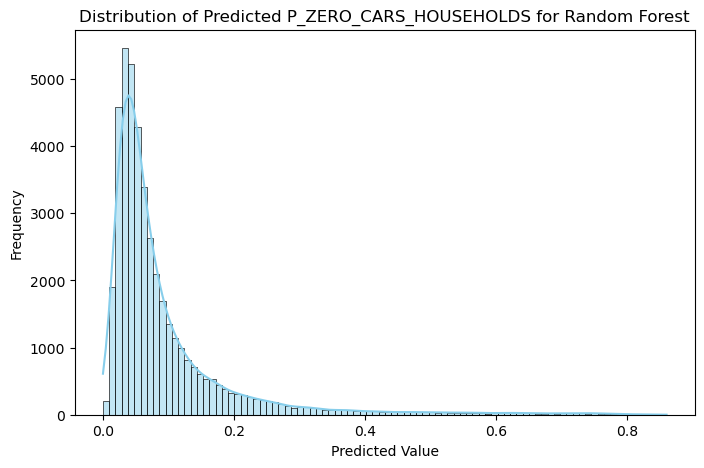

In [45]:
y_pred = RF_model.predict(X_test_scaled)

# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(y_pred, bins=90, kde=True, color='skyblue')
plt.title("Distribution of Predicted P_ZERO_CARS_HOUSEHOLDS for Random Forest")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.show()

The model does not predict these high numbers of records with 0 values

#### (iii) Threshold

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


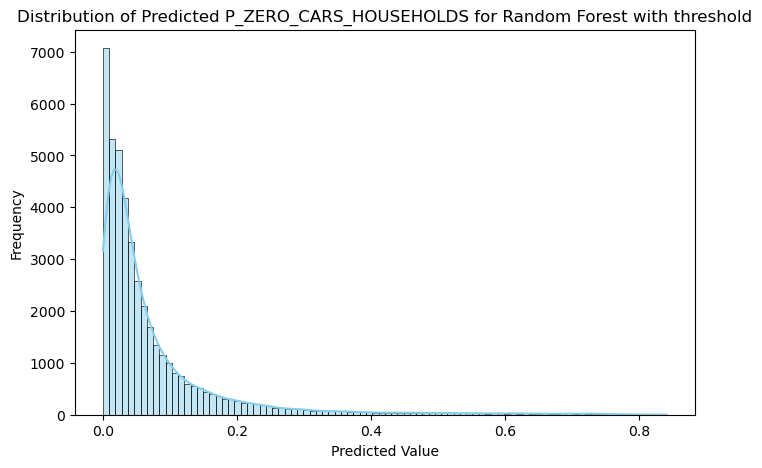

In [46]:
y_pred = RF_model.predict(X_test_scaled)

y_pred_adjusted = np.clip(y_pred - 0.02, 0, None)

# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(y_pred_adjusted, bins=90, kde=True, color='skyblue')
plt.title("Distribution of Predicted P_ZERO_CARS_HOUSEHOLDS for Random Forest with threshold")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.show()

If a threshold is used to fit the predicted data closer to the real data regarding the records with 0 values. The distribution look more the same.

In [47]:
metrics(y_test, y_pred_adjusted)

Mean Squared Error (MSE): 0.007249
Root Mean Squared Error (RMSE): 0.085143
Mean Absolute Error (MAE): 0.053554
R² (Coefficient of Determination): 0.6046


A threshold will worsen the metrics slightly.

This adjustment highlights a common trade-off: By improving the model’s ability to match the observed distribution, particularly by accurately identifying records with 0% zero-car households, we accept a slight reduction in overall performance metrics in exchange for better representational accuracy in the critical lower end of the distribution

### 5.6 Coefficient strength and uncertainty

100%|███████████████████████████████████████| 1000/1000 [00:56<00:00, 17.85it/s]



=== Bayesian Ridge Analysis ===

=== Random Forest Permutation Importance ===


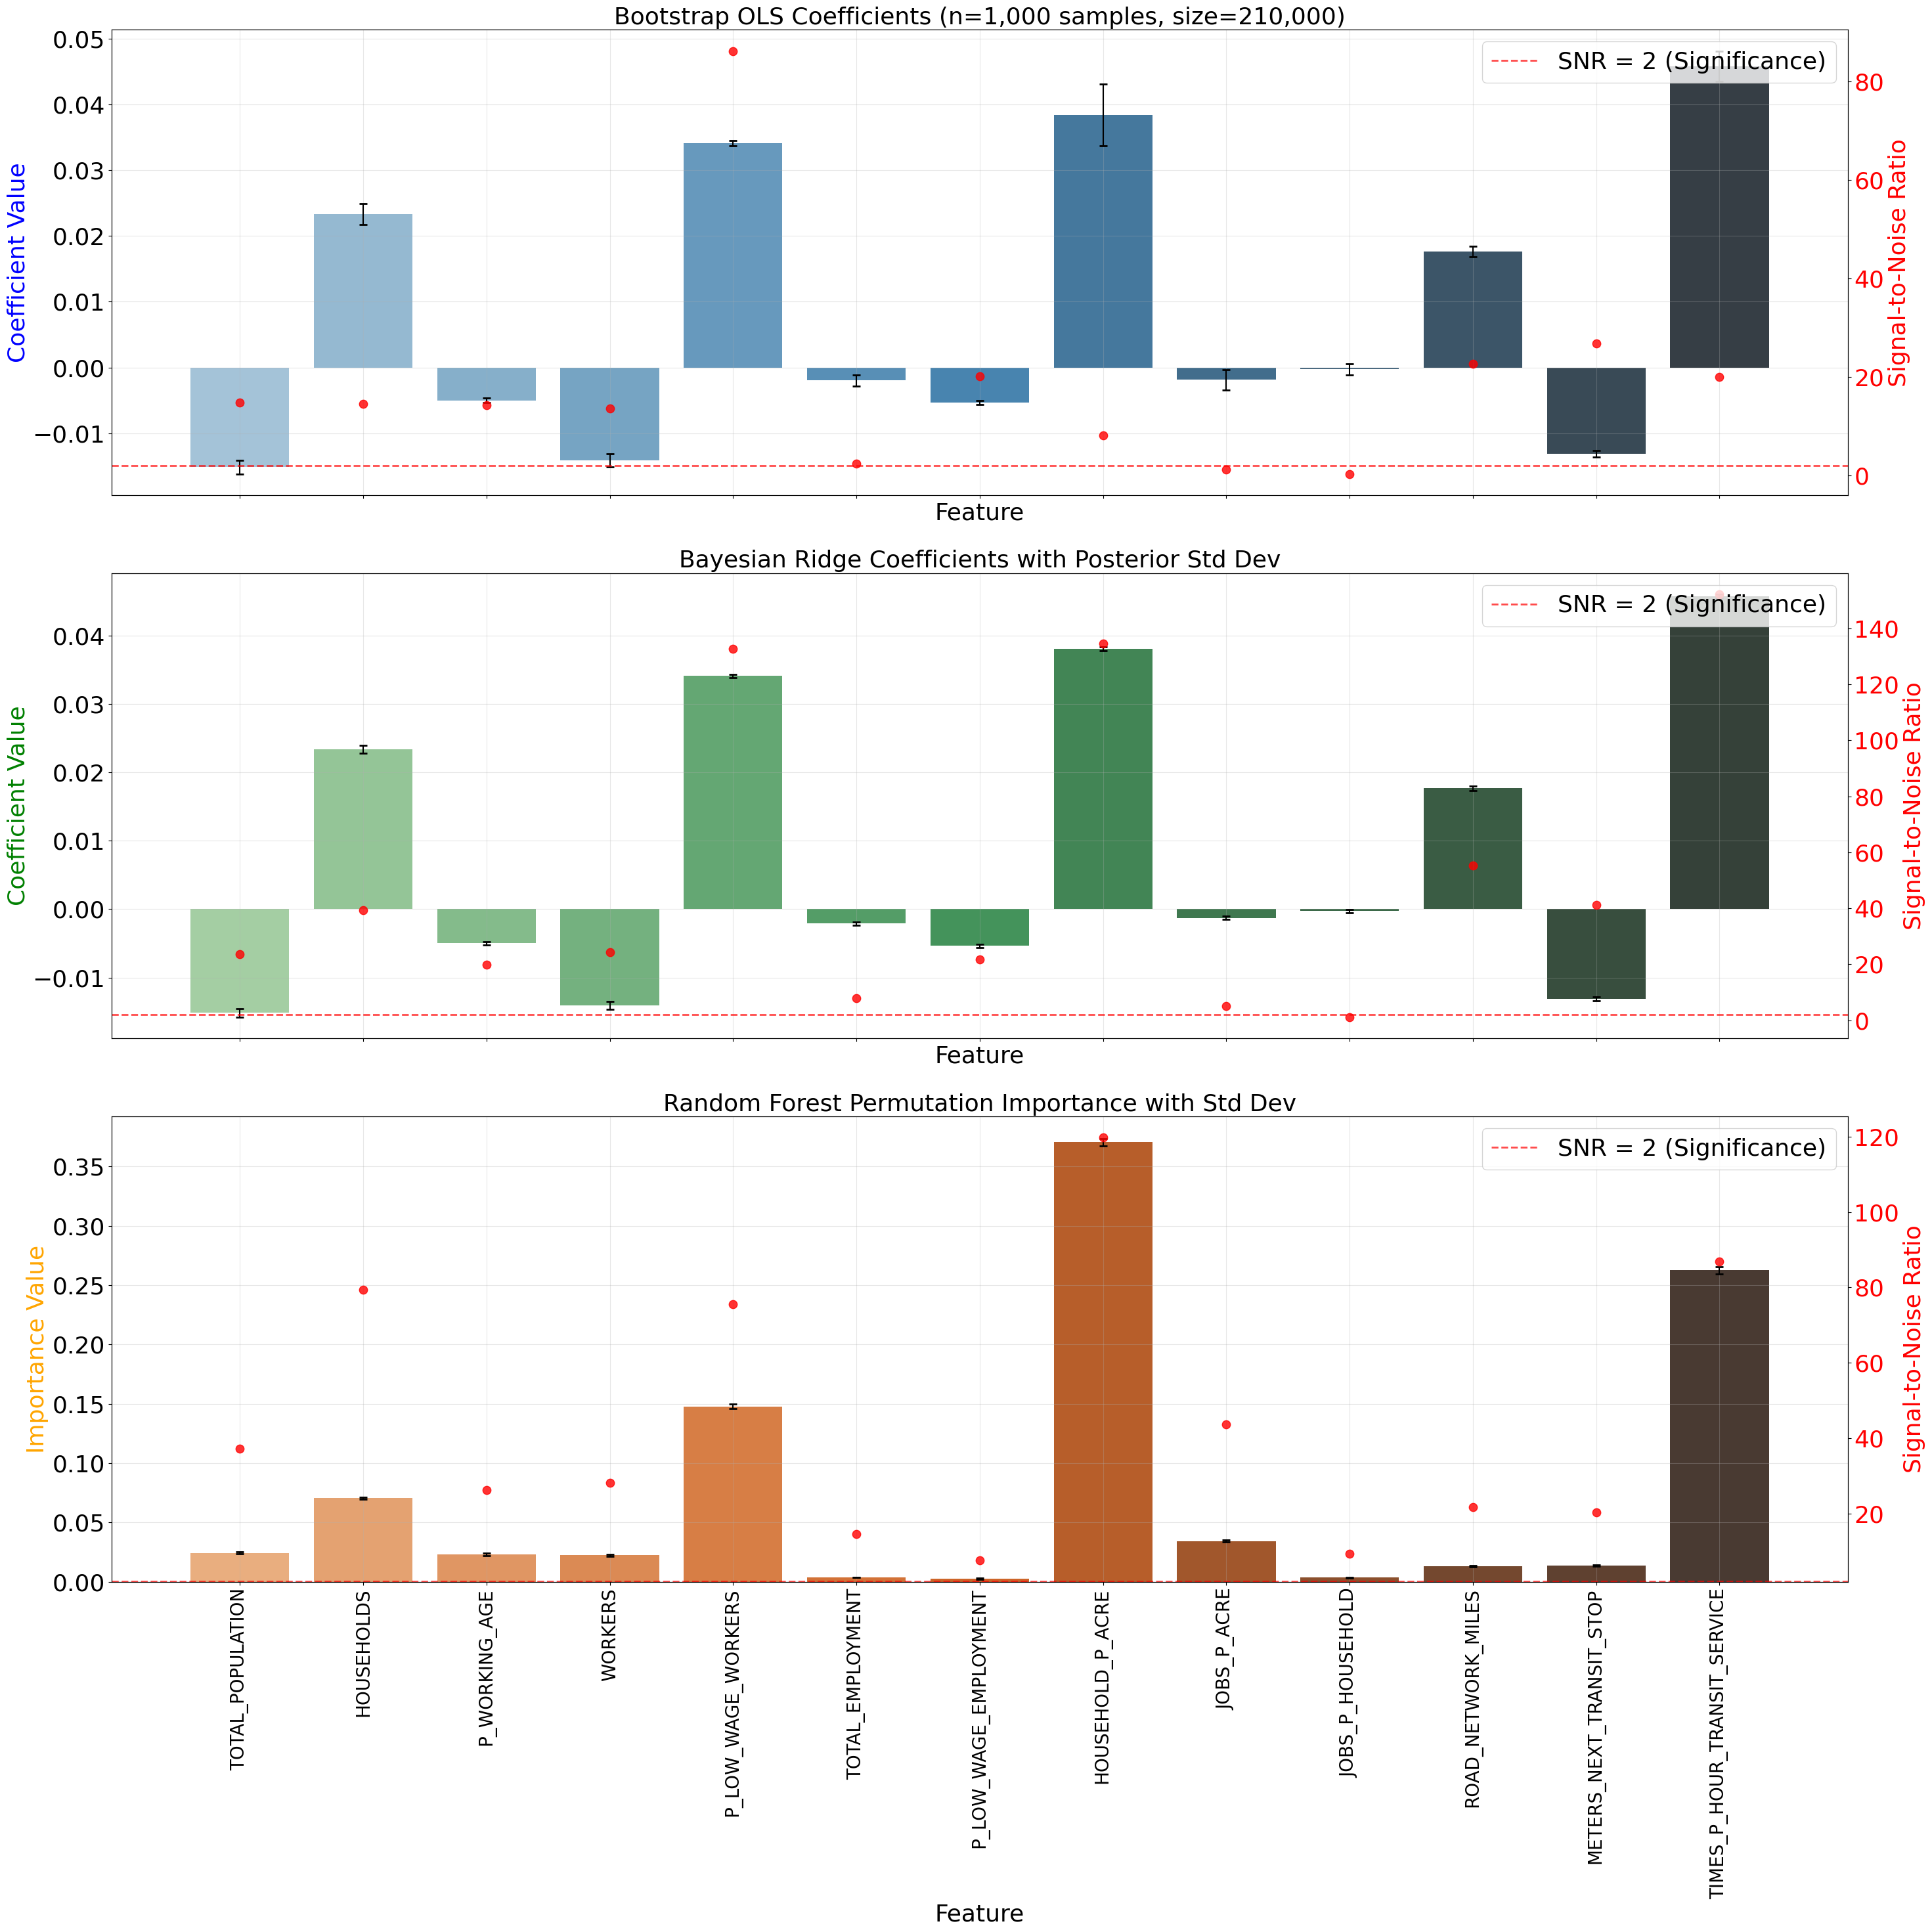


=== SNR Summary Statistics ===
Bootstrap OLS - Mean SNR: 18.86, Features with SNR ≥ 2: 11/13
Bayesian Ridge - Mean SNR: 50.64, Features with SNR ≥ 2: 12/13
Random Forest - Mean SNR: 43.89, Features with SNR ≥ 2: 13/13


In [48]:
plt.rcParams.update({
    'font.size': 26,          # Base font size
    'axes.titlesize': 26,     # Subplot titles
    'axes.labelsize': 26,     # Axis labels
    'xtick.labelsize': 20,    # X-axis tick labels
    'ytick.labelsize': 26,    # Y-axis tick labels
    'legend.fontsize': 26,    # Legend (if any)
    'figure.titlesize': 26    # Main figure title
})



# Bootstrap OLS coefficients and standard errors
#print("=== Bootstrap OLS Analysis ===")
ols_mean_coefs, ols_std_errors, all_bootstrap_coefs = bootstrap_ols_coefficients(
    X_train_scaled, y_train
)

ols_summary = pd.DataFrame({
    'Feature': X_train.columns,
    'Coef': ols_mean_coefs,
    'Std Err': ols_std_errors,
    'CV': ols_std_errors / np.abs(ols_mean_coefs),  # Coefficient of variation
    'SNR': np.abs(ols_mean_coefs) / ols_std_errors  # Signal-to-Noise Ratio
})

#print(f"Bootstrap completed! Sample statistics:")
#print(f"- Mean coefficient range: [{ols_mean_coefs.min():.4f}, {ols_mean_coefs.max():.4f}]")
#print(f"- Mean std error: {ols_std_errors.mean():.4f}")

# Bayesian Ridge coefficients and std dev (unchanged)
print("\n=== Bayesian Ridge Analysis ===")
coef_summary = pd.DataFrame({
    'Feature': X_train.columns,
    'Mean Coef': Bayesian_model.coef_,
    'Std Dev': np.sqrt(np.diag(Bayesian_model.sigma_)),
    'SNR': np.abs(Bayesian_model.coef_) / np.sqrt(np.diag(Bayesian_model.sigma_))  # SNR
})

# Random Forest permutation importance (unchanged)
print("\n=== Random Forest Permutation Importance ===")
result = permutation_importance(
    RF_model, X_test_scaled, y_test, 
    n_repeats=30,
    random_state=43, 
    n_jobs=-1
)
df_perm = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std,
    'SNR': result.importances_mean / result.importances_std  # SNR
})


fig, axes = plt.subplots(3, 1, figsize=(30, 30), sharex=True)

# =============================================================================
# 1. Bootstrap OLS Coefficients with SNR
# =============================================================================
# Primary y-axis: Coefficients
sns.barplot(
    data=ols_summary,
    x='Feature', y='Coef',
    ax=axes[0], palette='Blues_d', errorbar=None
)
axes[0].errorbar(
    x=np.arange(len(ols_summary)),
    y=ols_summary['Coef'],
    yerr=ols_summary['Std Err'],
    fmt='none', c='black', capsize=4, capthick=2
)
axes[0].set_title(f'Bootstrap OLS Coefficients (n={N_BOOTSTRAP_SAMPLES:,} samples, size={BOOTSTRAP_SAMPLE_SIZE:,})')
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylabel('Coefficient Value', color='blue')

# Secondary y-axis: SNR
ax0_twin = axes[0].twinx()
ax0_twin.scatter(
    x=np.arange(len(ols_summary)),
    y=ols_summary['SNR'],
    color='red', s=80, alpha=0.8, marker='o', zorder=5
)
ax0_twin.axhline(y=2, color='red', linestyle='--', alpha=0.7, linewidth=2, label='SNR = 2 (Significance)')
ax0_twin.set_ylabel('Signal-to-Noise Ratio', color='red')
ax0_twin.tick_params(axis='y', labelcolor='red')
ax0_twin.legend(loc='upper right')

# =============================================================================
# 2. Bayesian Ridge Coefficients with SNR
# =============================================================================
# Primary y-axis: Coefficients
sns.barplot(
    data=coef_summary,
    x='Feature', y='Mean Coef',
    ax=axes[1], palette='Greens_d', errorbar=None
)
axes[1].errorbar(
    x=np.arange(len(coef_summary)),
    y=coef_summary['Mean Coef'],
    yerr=coef_summary['Std Dev'],
    fmt='none', c='black', capsize=4, capthick=2
)
axes[1].set_title('Bayesian Ridge Coefficients with Posterior Std Dev')
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylabel('Coefficient Value', color='green')

# Secondary y-axis: SNR
ax1_twin = axes[1].twinx()
ax1_twin.scatter(
    x=np.arange(len(coef_summary)),
    y=coef_summary['SNR'],
    color='red', s=80, alpha=0.8, marker='o', zorder=5
)
ax1_twin.axhline(y=2, color='red', linestyle='--', alpha=0.7, linewidth=2, label='SNR = 2 (Significance)')
ax1_twin.set_ylabel('Signal-to-Noise Ratio', color='red')
ax1_twin.tick_params(axis='y', labelcolor='red')
ax1_twin.legend(loc='upper right')

# =============================================================================
# 3. Random Forest Importance with SNR
# =============================================================================
# Primary y-axis: Importance
sns.barplot(
    data=df_perm,
    x='Feature', y='Importance Mean',
    ax=axes[2], palette='Oranges_d', errorbar=None
)
axes[2].errorbar(
    x=np.arange(len(df_perm)),
    y=df_perm['Importance Mean'],
    yerr=df_perm['Importance Std'],
    fmt='none', c='black', capsize=4, capthick=2
)
axes[2].set_title('Random Forest Permutation Importance with Std Dev')
axes[2].tick_params(axis='x', rotation=90)
axes[2].grid(True, alpha=0.3)
axes[2].set_ylabel('Importance Value', color='orange')

# Secondary y-axis: SNR
ax2_twin = axes[2].twinx()
ax2_twin.scatter(
    x=np.arange(len(df_perm)),
    y=df_perm['SNR'],
    color='red', s=80, alpha=0.8, marker='o', zorder=5
)
ax2_twin.axhline(y=2, color='red', linestyle='--', alpha=0.7, linewidth=2, label='SNR = 2 (Significance)')
ax2_twin.set_ylabel('Signal-to-Noise Ratio', color='red')
ax2_twin.tick_params(axis='y', labelcolor='red')
ax2_twin.legend(loc='upper right')

plt.tight_layout()
plt.show()

# =============================================================================
# Optional: Print SNR summaries
# =============================================================================
print("\n=== SNR Summary Statistics ===")
print(f"Bootstrap OLS - Mean SNR: {ols_summary['SNR'].mean():.2f}, Features with SNR ≥ 2: {(ols_summary['SNR'] >= 2).sum()}/{len(ols_summary)}")
print(f"Bayesian Ridge - Mean SNR: {coef_summary['SNR'].mean():.2f}, Features with SNR ≥ 2: {(coef_summary['SNR'] >= 2).sum()}/{len(coef_summary)}")
print(f"Random Forest - Mean SNR: {df_perm['SNR'].mean():.2f}, Features with SNR ≥ 2: {(df_perm['SNR'] >= 2).sum()}/{len(df_perm)}")

In [49]:
#OLS
print(ols_summary)

                         Feature      Coef   Std Err        CV        SNR
0               TOTAL_POPULATION -0.015153  0.001021  0.067390  14.838948
1                     HOUSEHOLDS  0.023320  0.001600  0.068595  14.578343
2                  P_WORKING_AGE -0.005002  0.000350  0.069995  14.286829
3                        WORKERS -0.014107  0.001041  0.073789  13.552106
4             P_LOW_WAGE_WORKERS  0.034125  0.000396  0.011604  86.174172
5               TOTAL_EMPLOYMENT -0.001973  0.000808  0.409250   2.443493
6          P_LOW_WAGE_EMPLOYMENT -0.005328  0.000265  0.049781  20.087979
7               HOUSEHOLD_P_ACRE  0.038359  0.004704  0.122631   8.154576
8                    JOBS_P_ACRE -0.001870  0.001554  0.830936   1.203462
9               JOBS_P_HOUSEHOLD -0.000274  0.000885  3.228574   0.309734
10            ROAD_NETWORK_MILES  0.017639  0.000778  0.044131  22.659688
11      METERS_NEXT_TRANSIT_STOP -0.013082  0.000487  0.037228  26.861373
12  TIMES_P_HOUR_TRANSIT_SERVICE  0.04

In [50]:
#Bayesian
print(coef_summary)

                         Feature  Mean Coef   Std Dev         SNR
0               TOTAL_POPULATION  -0.015170  0.000645   23.531370
1                     HOUSEHOLDS   0.023359  0.000594   39.348830
2                  P_WORKING_AGE  -0.004995  0.000252   19.812482
3                        WORKERS  -0.014094  0.000580   24.295514
4             P_LOW_WAGE_WORKERS   0.034110  0.000257  132.693890
5               TOTAL_EMPLOYMENT  -0.002112  0.000269    7.856182
6          P_LOW_WAGE_EMPLOYMENT  -0.005350  0.000247   21.645669
7               HOUSEHOLD_P_ACRE   0.038051  0.000283  134.553668
8                    JOBS_P_ACRE  -0.001291  0.000256    5.037566
9               JOBS_P_HOUSEHOLD  -0.000263  0.000248    1.058863
10            ROAD_NETWORK_MILES   0.017689  0.000321   55.156906
11      METERS_NEXT_TRANSIT_STOP  -0.013135  0.000320   41.088232
12  TIMES_P_HOUR_TRANSIT_SERVICE   0.045749  0.000301  152.201372


In [51]:
# Random Forest
print(df_perm)

                         Feature  Importance Mean  Importance Std         SNR
0               TOTAL_POPULATION         0.024404        0.000657   37.158842
1                     HOUSEHOLDS         0.070381        0.000887   79.345834
2                  P_WORKING_AGE         0.023026        0.000876   26.289520
3                        WORKERS         0.022365        0.000796   28.085033
4             P_LOW_WAGE_WORKERS         0.147715        0.001953   75.636668
5               TOTAL_EMPLOYMENT         0.003647        0.000249   14.619678
6          P_LOW_WAGE_EMPLOYMENT         0.002596        0.000345    7.519772
7               HOUSEHOLD_P_ACRE         0.370526        0.003093  119.780103
8                    JOBS_P_ACRE         0.034170        0.000782   43.699865
9               JOBS_P_HOUSEHOLD         0.003503        0.000378    9.274835
10            ROAD_NETWORK_MILES         0.012911        0.000593   21.773137
11      METERS_NEXT_TRANSIT_STOP         0.013584        0.00066

Magnitude and direction (Linear models):
Both Bayesian Ridge and OLS yield similar coefficients but with different uncertainty patterns. OLS bootstrapping reveals high standard errors for many features, honestly reflecting the difficulty of fitting linear models to non-linear relationships. For example, TIMES_P_HOUR_TRANSIT_SERVICE has the strongest positive linear association across both models. Interestingly, linear models favor POPULATION_P_ACRE over HOUSEHOLD_P_ACRE (despite their high correlation), showing moderate positive effects. However, Bayesian Ridge shows suspiciously low uncertainties - likely because it's forcing linear assumptions on inherently non-linear data, leading to overconfident but potentially misleading estimates.

Magnitude only (Random Forest):
Random Forest importance reflects feature relevance without direction, capturing non-linearities and interactions. Notably, while POPULATION_P_ACRE and HOUSEHOLD_P_ACRE are nearly identical measures, Random Forest strongly prefers HOUSEHOLD_P_ACRE as its highest importance feature - with much higher importance than linear models assign to either density measure. This suggests the model identifies non-linear threshold effects or interactions that linear models cannot capture. TIMES_P_HOUR_TRANSIT_SERVICE also shows high importance with low standard errors and high signal-to-noise ratios.

Consistency:
Features such as TIMES_P_HOUR_TRANSIT_SERVICE and P_LOW_WAGE_WORKERS are important across both linear and Random Forest models, increasing confidence in their true impact. Transit frequency shows consistent importance despite model differences.

Discrepancies:
The most striking discrepancy involves the density measures. Despite HOUSEHOLD_P_ACRE and POPULATION_P_ACRE being highly correlated, linear models prefer population density while Random Forest strongly prefers household density - and assigns it much higher importance than linear models assign to either. This isn't just a preference switch; the dramatically higher importance in RF suggests it's capturing non-linear relationships (likely threshold effects where density suddenly makes car-free living viable). This contrast perfectly illustrates how linear models can miss critical non-linear patterns even in familiar variables.

Uncertainty:
The models show strikingly different uncertainty patterns. OLS (via bootstrapping) correctly identifies high uncertainty when fitting linear models to non-linear data. Bayesian Ridge's low uncertainties are likely artifacts of model misspecification - it's overconfident because it can't capture the true non-linear relationships. Random Forest shows the best signal-to-noise ratio with low standard errors on its importance estimates, suggesting it's both accurate and appropriately confident in its feature assessments.

### 5.7 Model uncertainty

In [52]:
# --- OLS Model ---
# Add constant (intercept)
X_train_const = sm.add_constant(X_train_scaled)
X_test_const = sm.add_constant(X_test_scaled)

# Fit OLS
ols_model = sm.OLS(y_train, X_train_const).fit()

# Get OLS predictions with standard errors of prediction
ols_pred = ols_model.get_prediction(X_test_const)
ols_pred_summary = ols_pred.summary_frame(alpha=0.05)  # 95% PI

# Extract mean prediction and standard deviation of prediction
y_pred_mean_ols = ols_pred_summary['mean'].values
# Calculate std from prediction intervals
y_pred_std_ols = (ols_pred_summary['obs_ci_upper'] - ols_pred_summary['obs_ci_lower']) / (2 * 1.96)

# --- Bayesian Ridge prediction + uncertainty ---
y_pred_mean_bayes, y_pred_std_bayes = Bayesian_model.predict(X_test_scaled, return_std=True)

# --- Random Forest prediction + uncertainty ---
all_tree_preds = np.stack([tree.predict(X_test_scaled) for tree in RF_model.estimators_], axis=0)
y_pred_mean_rf = np.mean(all_tree_preds, axis=0)
y_pred_std_rf = np.std(all_tree_preds, axis=0)

# --- Function to calculate coverage and average width ---
def uncertainty_metrics(y_true, y_pred_mean, y_pred_std, n_std=2):
    lower = y_pred_mean - n_std * y_pred_std
    upper = y_pred_mean + n_std * y_pred_std
    coverage = np.mean((y_true >= lower) & (y_true <= upper))
    avg_width = np.mean(upper - lower)
    mean_std = np.mean(y_pred_std)
    median_std = np.median(y_pred_std)
    return coverage, avg_width, mean_std, median_std

# --- Calculate metrics ---
coverage_ols, width_ols, mean_std_ols, median_std_ols = uncertainty_metrics(
    y_test.values, y_pred_mean_ols, y_pred_std_ols)

coverage_bayes, width_bayes, mean_std_bayes, median_std_bayes = uncertainty_metrics(
    y_test.values, y_pred_mean_bayes, y_pred_std_bayes)

coverage_rf, width_rf, mean_std_rf, median_std_rf = uncertainty_metrics(
    y_test.values, y_pred_mean_rf, y_pred_std_rf)

# --- Print results ---
print("OLS Prediction Uncertainty:")
print(f"  Coverage (±2 std): {coverage_ols:.3f}")
print(f"  Avg Interval Width: {width_ols:.4f}")
print(f"  Mean Predictive Std: {mean_std_ols:.5f}")
print(f"  Median Predictive Std: {median_std_ols:.5f}\n")

print("Bayesian Ridge Prediction Uncertainty:")
print(f"  Coverage (±2 std): {coverage_bayes:.3f}")
print(f"  Avg Interval Width: {width_bayes:.4f}")
print(f"  Mean Predictive Std: {mean_std_bayes:.5f}")
print(f"  Median Predictive Std: {median_std_bayes:.5f}\n")

print("Random Forest Prediction Uncertainty:")
print(f"  Coverage (±2 std): {coverage_rf:.3f}")
print(f"  Avg Interval Width: {width_rf:.4f}")
print(f"  Mean Predictive Std: {mean_std_rf:.5f}")
print(f"  Median Predictive Std: {median_std_rf:.5f}")


OLS Prediction Uncertainty:
  Coverage (±2 std): 0.953
  Avg Interval Width: 0.4021
  Mean Predictive Std: 0.10052
  Median Predictive Std: 0.10052

Bayesian Ridge Prediction Uncertainty:
  Coverage (±2 std): 0.953
  Avg Interval Width: 0.4021
  Mean Predictive Std: 0.10052
  Median Predictive Std: 0.10052

Random Forest Prediction Uncertainty:
  Coverage (±2 std): 0.925
  Avg Interval Width: 0.2286
  Mean Predictive Std: 0.05716
  Median Predictive Std: 0.04732




**Model Uncertainty Comparison:**

Both OLS and Bayesian Ridge show identical uncertainty patterns with near-ideal coverage (95.3%) but **practically useless** interval widths of 40%. For a variable constrained between 0 and 1, these intervals are so wide they provide little actionable information - essentially saying "the value could be anywhere." This reveals a fundamental limitation: while the linear models are mathematically correct about their uncertainty, they're admitting they can't make precise predictions due to model misspecification.

Random Forest offers better but still imperfect performance: 92.5% coverage with narrower 23% intervals. While this is a substantial improvement over the linear models' 40% intervals, even 23% width remains quite large for practical planning purposes.

**Real-World Performance Check:**
When we examine prediction accuracy within ±3% (a practical threshold for planning decisions):
- OLS & Bayesian Ridge: Only 35% accurate - disappointing given their massive uncertainty intervals
- Random Forest: Moderately better at ~43% - more respectable but shows the inherent difficulty of this prediction task

**Key Insight:**
The linear models' identical, extremely wide intervals suggest they're both recognizing the same fundamental problem: they cannot adequately model the non-linear relationships in the data. Their 40% intervals are essentially an admission of model inadequacy. Random Forest's narrower intervals and better accuracy indicate it's capturing more of the true data structure, though even its 23% intervals show that precise car-free household prediction remains challenging. The combination of coverage analysis and practical accuracy testing reveals that while Random Forest is clearly superior, all models struggle with the complexity of this real-world prediction task.

#### Smaller intervals and special areas of prediction range

In [53]:
# Function to compute fraction within ±3% absolute error
def within_5_percent(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) <= 0.03)

# True values for full test set
y_true_all = y_test.values

# Predictions for full test set
y_pred_bayes_all = y_pred_mean_bayes
y_pred_rf_all = y_pred_mean_rf
y_pred_ols_all = ols_model.predict(sm.add_constant(X_test_scaled))

# Calculate accuracy for full data
acc_bayes_all = within_5_percent(y_true_all, y_pred_bayes_all)
acc_rf_all = within_5_percent(y_true_all, y_pred_rf_all)
acc_ols_all = within_5_percent(y_true_all, y_pred_ols_all)

print("Prediction accuracy within ±3% absolute error for ALL CBGs:")
print(f"Bayesian Ridge: {acc_bayes_all:.3f}")
print(f"Random Forest:  {acc_rf_all:.3f}")
print(f"OLS:            {acc_ols_all:.3f}")


Prediction accuracy within ±3% absolute error for ALL CBGs:
Bayesian Ridge: 0.351
Random Forest:  0.427
OLS:            0.351


In [54]:
# Define cutoff at 10%
high_value_cutoff = 0.10

# Mask for CBGs with no-car households >= 10%
high_value_mask = y_test.values >= high_value_cutoff

# True values and predictions for this subset
y_true_high = y_test.values[high_value_mask]
y_pred_bayes_high = y_pred_mean_bayes[high_value_mask]
y_pred_rf_high = y_pred_mean_rf[high_value_mask]
y_pred_ols_high = ols_model.predict(sm.add_constant(X_test_scaled))[high_value_mask]

# Function to calculate % within ±5%
def within_5_percent(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) <= 0.05)

# Calculate accuracy for the high no-car subset
acc_bayes_high = within_5_percent(y_true_high, y_pred_bayes_high)
acc_rf_high = within_5_percent(y_true_high, y_pred_rf_high)
acc_ols_high = within_5_percent(y_true_high, y_pred_ols_high)

print(f"Prediction accuracy within ±5% for CBGs with ≥10% no-car households:")
print(f"Bayesian Ridge: {acc_bayes_high:.3f}")
print(f"Random Forest: {acc_rf_high:.3f}")
print(f"OLS: {acc_ols_high:.3f}")


Prediction accuracy within ±5% for CBGs with ≥10% no-car households:
Bayesian Ridge: 0.338
Random Forest: 0.310
OLS: 0.338


## 6 Results

- Present key findings
- Comparison of models if multiple approaches were used

## 7 Discussion

- Interpretation of results
- Limitations of the approach
- Possible improvements or extensions

## 8 Conclusion

- Summary of main outcomes

## 9 References

- Cite any papers, datasets, or tools used